In [ ]:
'''
06/06/25
for now this is a notebook, but if the plan is to automate,
it will become a .py file that can be executed by terminal
'''

# NB - HAS TROUBLE WRITING TO ONEDRIVE
import cv2
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output


def show_frame(frame):
    '''sort of obsolete. function to show video inline. but prefered 
    method is just writing a new video mp4.'''
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()


def video_writer(outpath, input_info):
    '''outpath = output path, input_info = (fps, width, height). Checks output is mp4 format,
    iterates over each available codec and tries to open VideoWriter with it.'''
    fps, width, height = input_info

    # regex pattern to seach for in the outpath string
    pattern = r'\.mp4$'
    if re.search(pattern, outpath, re.IGNORECASE):  # True if found
        # list of apparently suitable codecs for mp4 format
        codecs = ['mp4v', 'avc1', 'H264', 'X264']
    else:
        print('output path not .mp4 coded')
        return
    # iterates over all available codecs trying each one with VideoWriter
    for codec in codecs:
        try:
            fourcc = cv2.VideoWriter_fourcc(*codec)
            video_out = cv2.VideoWriter(outpath, fourcc, fps, (width, height))
            
            if video_out.isOpened():
                print(f"Successfully opened VideoWriter with codec: {codec}")
                return video_out
            else:
                print(f"Failed to open VideoWriter with codec: {codec}")
        except Exception as e:
            print(f"Error with codec {codec}: {str(e)}")
    print('Error: no codec could open VideoWriter.')
    return None


def get_relative_COR(p1a, p2a, centre, frame):
    '''input: p1a, p2a, centre, frame, output: draws lines and returns
    [length_along, length_perp].'''
    p1a = np.array(p1a)
    p2a = np.array(p2a)
    probe_line = p2a - p1a     # direction vector of line A
    
    length_line = np.sqrt( (p2a[0] - p1a[0])**2 + (p2a[1] - p1a[1])**2 )

    if probe_line[0] == 0.0 and probe_line[1] == 0.0:
        return [0, 0]  # handles error where probe_line = 0. Is this from rematch() ?

    centre = np.array(centre)  # centre point
    point_2a = np.array(p2a)   # could be any point on probe line        
    
    # vector from centre to point on the line
    vec = centre - point_2a
    
    # projection of vector onto probe line
    length_along = (np.dot(vec, probe_line) / np.dot(probe_line, probe_line)) 

    # location of the foot along the line relative to point 2a
    vec_parallel = length_along * probe_line
    
    # foot of the perpendicular (intersection point on line A)
    point_c = point_2a + vec_parallel
    point_c = [int(point_c[0]), int(point_c[1])]

    # distance from COR to the foot
    length_perp = np.sqrt( (point_c[0] - centre[0])**2 + (point_c[1] - centre[1])**2 )

    # writing to the frame
    # cv2.circle(img, centre, radius, colour, thickness=-1 fills it)
    # cv2.line(frame, p1, p2, (RGB), thickness)
    cv2.circle(frame, point_c, 4, (165, 0, 0), -1)
    cv2.line(frame, point_c, centre, (165, 165, 0), 3)
    
    return [length_along, length_perp]
            

In [ ]:
'''NEW PLAN
generate a video of a red line spinning about some known point.
develop the code to analyse said video and determine the point of
rotation to validate the code before drop tests.'''

def test_data(outpath, centre=[165, 255], p1=[200, 250], p2=[350, 250],
              rotations=8, amplitude=0, thickness=2, validate=False):
    '''creates mp4 file of spinning red line for analysis and validation.
    outpath: video output path, optional: centre of rotation, line endpoints,
    and number of complete rotations'''
    
    # video settings
    width, height = 500, 500
    fps = 30
    total_time = 5
    total_frames = fps * total_time

    # saving to mp4 format
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(outpath, fourcc, fps, (width, height))
    if not video_out.isOpened():
        print("VideoWriter failed to open.")
        exit()
    
    # rotation settings
    centre = np.array(centre, dtype=np.float32)  # tuple input (x, y) refers to pixel
    angle_step = rotations * 2 * np.pi / total_frames  # rotation per frame

    # centres for comparison
    centres = []
    
    for i in range(total_frames):
        # makes the white background
        frame = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # the line
        x1, y1 = p1
        x2, y2 = p2

        line_1 = np.array([x1, y1], dtype=np.float32)
        line_2 = np.array([x2, y2], dtype=np.float32)

        # introducing some translational motion, oscillates around x and y
        centre[0] = centre[0] + ( np.sin(i * angle_step) * amplitude )
        centre[1] = centre[1] + ( np.cos(i * angle_step) * amplitude )

        # relative vectors (all numpy arrays)
        vec_1 = line_1 - centre
        vec_2 = line_2 - centre
        
        # angle
        angle = angle_step * i

        # 
        rotation_matrix = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle),  np.cos(angle)]
        ], dtype=np.float32)
        
        # matrix multiplication w @ (replaces np.matmul(A,B))
        rotated_1 = rotation_matrix @ vec_1 + centre
        rotated_2 = rotation_matrix @ vec_2 + centre
        
        # line
        cv2.line(frame,
                tuple(rotated_1.astype(int)),
                tuple(rotated_2.astype(int)),
                (0, 0, 255), thickness)  # cv2 is BGR
        # pivot
        cv2.circle(frame, tuple(centre.astype(int)), 4, (0, 0, 0), -1)

        # for comparison
        centres.append((centre[0], centre[1]))
        
        video_out.write(frame)
        
    video_out.release()
    print(f"Video saved as {outpath}")
    if validate is True:
        return centres


def colour_mask(frame, colour="red"):
    '''input: frame. returns: mask. Potential to have HSV lookup table
    for different colours, but we will probably use red.'''
    # threshold for red in HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    if colour == "red":
        # red wraps round two bands of the HSV spectrum
        lower_red1 = np.array([0, 100, 100])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # turns all pixels to black if not in the HSV red ranges
        # and combines the two masks
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)
        
        return mask
    
    elif colour == "blue":
        # these HSV values work really well for the probe colour
        lower_blue = np.array([100, 150, 100])  # H, S, V
        upper_blue = np.array([130, 255, 255])
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
        return mask


def detect_line(mask):
    '''input: mask. returns: tuple, tuple. If lines not none,
    returns point 1 and 2 coords.'''
    # canny removes noise with a 5x5 gaussian filter,
    # converts a normal image into a sketch made up of lines only.
    edges = cv2.Canny(mask, 50, 150)  # args min and max val - threshold for edge
    
    # line detection - Hough algorithm probabilistic
    # OR with high contrast - use cv2.findNonZero() to directly fit a line
    # w/ cv2.fitLine
    # =======================================================
    # HoughLines expresses line in polar coords. Intersections define points
    # belonging to the same line. Threshold is min intersections to define line
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100,
                            minLineLength=50, maxLineGap=20)

# lines is an array([[[x1, y1, x2, y2]],
#                    [[x1, y1, x2, y2]])
# lines[0][0] is = line[0]

    if lines is not None:
        # finding the longest line and returning the end points
        # again probably overkill for one line as long as the mask works
        longest = None        
        max_len = 0
        for line in lines:
        # line is lines[i] and line[0] just extracts [x1, y1, x2, y2]
            x1, y1, x2, y2 = line[0]
            # length = np.hypot(x2 - x1, y2 - y1)
            length = np.sqrt( (x2 - x1)**2 + (y2 - y1)**2)
            if length > max_len:
                max_len = length
                longest = line[0]

        if longest is not None:
            x1, y1, x2, y2 = longest
            return [x1, y1], [x2, y2]
        
    return None, None  # no lines found


def fit_line(mask):
    '''
    fitLine(args):
    points=NxN
    distType=DIST_L2 is Euclidean least sqrs distance
    param=0 (distance types)
    reps=relative accuarcy
    aeps=absolute accuracy.
    returns: [vector_x, vector_y, and two points (x, y)]. x(t) = x0 + t*xv'''
    points = cv2.findNonZero(mask)  # simply finds all nonzero points on binary mask
    if points is None or len(points) <= 3:
        print("no points found in mask")
        return None, None
    [xv, yv, x0, y0] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
    direction = np.array([xv, yv]).reshape(2)
    origin = np.array([x0, y0]).reshape(2)

    projections = []
    for p in points:
        pt = p[0].astype(np.float32)
        rel = pt - origin
        t = np.dot(rel, direction)
        proj = origin + t * direction
        projections.append((t, proj))

    projections.sort(key=lambda x: x[0])
    p1 = projections[0][1]
    p2 = projections[-1][1]
    return [int(p1[0]), int(p1[1])], [int(p2[0]), int(p2[1])]


def fit_rectangle(frame):
    '''fits contour to binary mask and finds the largest area contour.
    fits a rectangle to the contour and obtains centre, area and angle of orientation.
    returns p1, p2.'''
    mask = colour_mask(frame, colour='blue')
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    largest = max(contours, key=cv2.contourArea)

    # fit a MINIMUM area rectangle 
    rectangle = cv2.minAreaRect(largest)
    centre, size, angle = rectangle
    x0, y0 = centre
    width, height = size

    box = cv2.boxPoints(rectangle)
    box = np.intp(box)  # converts to integer. intp depends on system (32/64-bit int)
    cv2.drawContours(frame, [box], 0, (0, 0, 255), 2)  # can write to frame inside function
                                                       # don't need to pass out new frame.

    # width and height not necessarily longer than the other. we choose height as 
    # the reference
    if width < height:
        angle_rad = np.deg2rad(angle)
        mid_len = height / 2
    else:
    # this is so that if width is greater than height, the correct 
    # orientation is still maintained
        angle_rad = np.deg2rad(angle + 90)
        mid_len = width / 2

    xvec = np.cos(angle_rad)
    yvec = np.sin(angle_rad)

    p1 = [int(x0 - xvec * mid_len), int(y0 - yvec * mid_len)]
    p2 = [int(x0 + xvec * mid_len), int(y0 + yvec * mid_len)]

    return p1, p2
    
    
def midpoint(p1, p2):
    '''gets midpoint from two pairs of coords'''
    midp = np.array([(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2])
    return midp


def get_angle(p1a, p2a, p1b, p2b):
    '''input: 4 points, output: angle in radians.'''
    lineA = [(p1a[0] - p2a[0]), (p1a[1] - p2a[1])]  # [(x0-x1),(y0-y1)]
    lineB = [(p1b[0] - p2b[0]), (p1b[1] - p2b[1])]
    
    scalar_product = np.dot(lineA, lineB)
    
    magA = np.sqrt(np.dot(lineA, lineA))
    magB = np.sqrt(np.dot(lineB, lineB))
    
    cosine_value = scalar_product / (magA * magB)
    
    return np.arccos(cosine_value)


def rematch(p1a, p2a, p1b, p2b):
    '''handle error where point 1 is mapped to point 2 over time step.'''
    length_11 = np.hypot(p1b[0] - p1a[0], p1b[1] - p1a[1])
    length_12 = np.hypot(p2b[0] - p1a[0], p2b[1] - p1a[1])
    if length_11 > length_12:
        # swaps one endpoint
        return p2a, p1a, p1b, p2b
    else:
        return p1a, p2a, p1b, p2b
    

def rotation_speed(p1a, p2a, p1b, p2b, frameB_count, frameA_count, fps):
    '''takes the points and calculates the speed of rotation.'''
    timestep = (frameB_count - frameA_count) / fps
    angle = get_angle(p1a, p2a, p1b, p2b)
    
    speed = angle / timestep
    return speed


def in_frame(centre, width, height):
    '''checks to see if the calculated centre point is in the frame'''
    if centre[0] < 0 or centre[0] > width:
        return False
    if centre[1] < 0 or centre[1] > height:
        return False
    else:
        return True
    

def validate(input, output, plot=True, p1=[200, 250], p2=[350, 250], amplitude=0):
    '''compare the real centre of rotation with the calculated one.'''
    line_length = np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )
    # true COR
    true_centres = test_data(input, centre=[205, 235], thickness=2, 
                             amplitude=amplitude, validate=True)
    # extracted COR
    new_centres = main_COR(input, output, validate=True)
    residual = []
    for i, tuple in enumerate(true_centres[1:]):
        true_x = tuple[0]; true_y = tuple[1]
        new_tuple = new_centres[i]
        x = new_tuple[0]; y = new_tuple[1]
        # r = np.sqrt(x**2 + y**2)
        # true_r = np.sqrt(true_x**2 + true_y**2)
        # difference = np.abs(r - true_r)
        difference = np.sqrt( (x - true_x)**2 + (y - true_y)**2 )
        residual.append(difference / line_length)
    if plot is True:  
        plt.scatter(np.arange(len(new_centres)), residual)
        plt.title('validation of centre of rotation finding code')
        plt.xlabel('timestep')
        plt.ylabel(f'difference / line length ({line_length})')
        plt.show()


def mask_check(inpath, outpath, start_time=0):
    '''input: file to analyse, output: path to analysed video. video of mask.'''
    # loading input
    cap = cv2.VideoCapture(inpath)
    # matches the new video to the old video specifications
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # skips ahead ||| MAKE SURE PROBE IS VISIBLE FROM THE FILM START |||
    start_frame = int(start_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    # saving output to mp4 format
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(outpath, fourcc, fps, (width, height))
    if not video_out.isOpened():
        print("mask_check: VideoWriter failed to open.")
        return
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # filtering for red and then using 
        mask = colour_mask(frame, colour='red')
        video_out.write(mask)
    cap.release()
    video_out.release()
    print(f"Video saved as {outpath}")
        

def get_COR(p1a, p2a, p1b, p2b, frame):
    '''1 and 2 refer to endpoints, a and b refer to times.'''
    # v1 and v2 are vectors between the two timelapses.
    v1 = p1b - p1a
    v2 = p2b - p2a
    # if new distance is too small, the perpendicular lines will have high error rate
#     if np.linalg.norm(v1) < 1e-8 or np.linalg.norm(v2) < 1e-8:  # is this actually useful?
#         print("perp lines too small")
#         return None

    # calculate the vector midpoint 
    m1 = midpoint(p1a, p1b)
    m2 = midpoint(p2a, p2b)
    
    # perpendicular bisector lines
    n1 = np.array([-v1[1], v1[0]])
    n2 = np.array([-v2[1], v2[0]])

    # won't work if vectors are parallel
    # this doesnt work for the test data
#     scalar_product = np.abs(np.dot(n1, n2))
#     if scalar_product > 0.999:
#         print("parallel vectors")
#         return None

    # builds matrix to solve linalg equation, form b = A @ x
    A = np.stack([n1, -n2], axis=1)
    b = m2 - m1
    
    # see lab book
    try:
        t = np.linalg.solve(A, b)
        centre = m1 + t[0] * n1
    except np.linalg.LinAlgError:
        # print("singular matrix error")
        return None

    # NEEDS TO BE INT FOR PLOTTING
    m1 = [int(m1[0]), int(m1[1])]
    m2 = [int(m2[0]), int(m2[1])]

    # how far to extend the perpendicular line
    scale_factor = 150 
    
    # for the first perpendicular bisector
    pt1pos = (
        m1[0] + int(n1[0] * scale_factor / np.linalg.norm(n1)),
        m1[1] + int(n1[1] * scale_factor / np.linalg.norm(n1))
    )
    pt1neg = (
        m1[0] - int(n1[0] * scale_factor / np.linalg.norm(n1)),
        m1[1] - int(n1[1] * scale_factor / np.linalg.norm(n1))
    )
    
    # for the second perpendicular bisector
    pt2pos = (
        m2[0] + int(n2[0] * scale_factor / np.linalg.norm(n2)),
        m2[1] + int(n2[1] * scale_factor / np.linalg.norm(n2))
    )
    pt2neg = (
        m2[0] - int(n2[0] * scale_factor / np.linalg.norm(n2)),
        m2[1] - int(n2[1] * scale_factor / np.linalg.norm(n2))
    )
    
    # draw line 1
    cv2.line(frame, pt1pos, pt1neg, (255, 0, 0), 1)
    cv2.line(frame, pt2pos, pt2neg, (255, 0, 0), 1)
    
    # draw from midpoint to extended points
    cv2.line(frame, m1, pt1pos, (255, 0, 0), 1)
    cv2.line(frame, m1, pt1neg, (255, 0, 0), 1)
    
    return (int(centre[0]), int(centre[1]))


def main_COR(inpath, outpath, skip_frame=1, start_time=0, end_time=None,
             validate=False, rel_COR=True):
    '''input: file to analyse, output: path to analysed video. optional:
    number of frames to skip to get centre, seconds of video to skip.'''
    # loading input
    if os.path.exists(inpath):
        cap = cv2.VideoCapture(inpath)
    else:
        print("main_COR: input file does not exist")
        return
    
    # matches the new video to the old video specifications
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    input_info = (fps, width, height)

    # skips ahead ||| MAKE SURE PROBE IS VISIBLE FROM THE FILM START ||| big obstacle for automation
    start_frame = int(start_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # saving output to mp4 format
    video_out = video_writer(outpath, input_info)

    # needed for rotational speed calc
    frame_info = []
    rot_list = []
    rot_speeds = []
    timestamps = []
    relative_centres = []
    frame_count = 0

    if end_time is not None:
        end_frame = int(end_time * fps)
    else:
        end_frame = 100000  # any large number
    
    while cap.isOpened() and frame_count <= end_frame:
        ret, frame = cap.read()
        # end of video
        if not ret:
            break
        
        # filtering for red and then using the binary mask ! NOT NEEDED FOR FIT_RECTANGLE
        # mask = colour_mask(frame, colour='red')
# =====================================================================
# ================== Choose depending on the problem ==================
        # p1, p2 = detect_line(mask)
        # p1, p2 = fit_line(mask)
        p1, p2 = fit_rectangle(frame)
        
        if p1 and p2 is not None:
            p1 = np.array(p1)
            p2 = np.array(p2)

            # just for tracking really not needed
            mid = midpoint(p1, p2)

            # storing this info for use in next part
            frame_info.append((frame_count, p1, p2))
            
# ============ COMPARING WITH PREVIOUS FRAMES TO FIND COR ==========
# A and B refer to time, 1 and 2 to endpoints again
            if len(frame_info) >= skip_frame + 1:
                # takes the info stored in the frame one skip ago
                frameA_count, p1a, p2a = \
                    frame_info[-(skip_frame + 1)]
                
                # compares to last frame (B is further ahead in time)
                frameB_count, p1b, p2b = \
                    frame_info[-1]
                
                # we will see if this matches the correct points based on length
                p1a, p2a, p1b, p2b = rematch(p1a, p2a, p1b, p2b)  

                # p1a, p2a, p1b, p2b
                centre = get_COR(p1a, p2a, p1b, p2b, frame)
                speed = rotation_speed(p1a, p2a, p1b, p2b, frameB_count, \
                                       frameA_count, fps)

# checks centre was calculated, is a coord, and is in the picture frame.
                if centre is not None and len(centre) == 2 and in_frame(centre, width, height) is True:
                    rot_list.append(centre)
                    rot_speeds.append(speed)
                    timestamps.append((frame_count - start_frame) / fps)

# cv2.circle(img, centre, radius, colour, thickness=-1 fills it)
# cv2.line(frame, p1, p2, (RGB), thickness)
                    # drawing previous line (darker red)
                    cv2.line(frame, p1a, p2a, (0, 0, 165), 3)
                    # midpoint
                    cv2.circle(frame, tuple(mid.astype(int)), 4, 
                                (0, 225, 225), -1)
                    # COR
                    cv2.circle(frame, centre, 6,
                                (0, 255, 0), 4)
                    # mapping lines
                    cv2.line(frame, p1a, p1b, (0, 255, 0), 3)
                    cv2.line(frame, p2a, p2b, (0, 255, 0), 3)
                    
                    #
                    if rel_COR is True:
                        rel_centre = get_relative_COR(p1a, p2a, centre, frame)
                        relative_centres.append(rel_centre)

                else:
                    # print("get_COR returned None")
                    exit()
                    
        video_out.write(frame)
            
        frame_count = frame_count + 1
    
    video_out.release()
    cap.release()
    print(f"Video saved as {outpath}")

    # Plot
    plt.plot(timestamps, rot_speeds)
    plt.xlabel('Time (s)')
    plt.ylabel('Angular velocity (rad/s)')
    plt.title('Rotational Velocity Over Time')
    plt.show()

    if rel_COR is True:
        plt.scatter([x[0] for x in relative_centres], [x[1] for x in relative_centres], s=1)
        plt.xlabel('along')
        plt.ylabel('perp')
        plt.title('')
        plt.show()
    
    if validate is True: 
        centres = np.array(rot_list)
        return centres




Successfully opened VideoWriter with codec: mp4v


C:\Users\rjvr0\AppData\Local\Temp\ipykernel_7912\1007245441.py:246: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cosine_value)
C:\Users\rjvr0\AppData\Local\Temp\ipykernel_7912\1007245441.py:244: RuntimeWarning: invalid value encountered in scalar divide
  cosine_value = scalar_product / (magA * magB)


Video saved as results/result_0612_115939.mp4
11.348596574884201


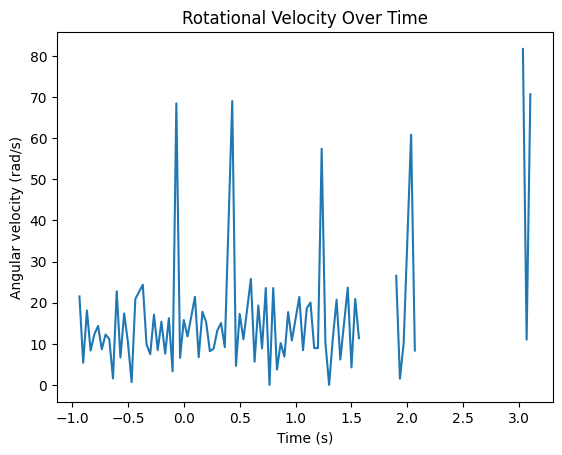

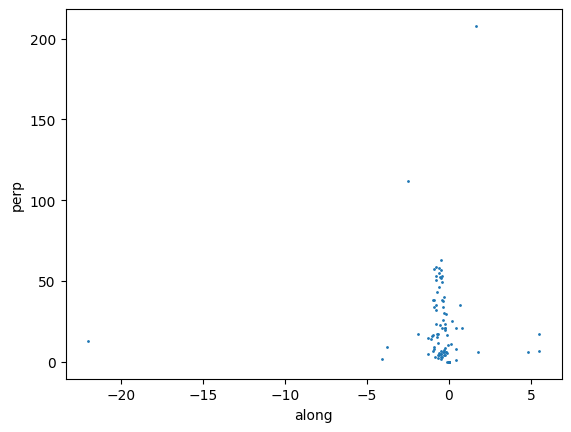

: 

In [ ]:
import datetime  # to avoid overwriting files
time = datetime.datetime.now()
timestamp = time.strftime("%m%d_%H%M%S")

# ifile = r"C:\Users\rj429\test_line_video.mp4"           # default simulated line video name
# ifile = r"C:\Users\rj429\M3R1S_145657152.mp4"           # thick red tape. start~3s
# ifile = r"C:\Users\rj429\M1B_R1S_145621480.mp4"         # thin tape diagonal
# ifile = r"M3R2S_155427.mp4"                             # thick red tape
# ifile = r"C:\Users\rj429\M1B_EXTENDED_UR1_154519.mp4"   # blue probe
# ifile = "M1B_EXTENDED_UR1_154519.mp4"
# ifile = r"C:\Users\rj429\M3HR2S_151220.mov"             # new data with blue tape, start~2
ifile = "M3UHR2SE_151556.mov"              # new data with blue tape, start~2

# ofile = r"C:\Users\rj429\test_data.mp4"
ofile = f"results/result_{timestamp}.mp4"

# main_COR(ifile, ofile, skip_frame=1, start_time=12, end_time=18)
# # mask_check(ifile, output, start_time=11)
# test_data(ifile, centre=[205, 235], thickness=2, amplitude=0)
main_COR(ifile, ofile, start_time=1, end_time=5, skip_frame=1)
# validate(ifile, ofile, amplitude=7)



In [2]:
import cv2
import numpy as np

# Create an HSV image with varying Hue, fixed Saturation and Value
hsv = np.zeros((100, 180, 3), dtype=np.uint8)
hsv[:, :, 0] = np.arange(180)            # Hue: 0 to 179
hsv[:, :, 1] = 255                       # Max Saturation
hsv[:, :, 2] = 255                       # Max Value

# Convert to BGR for display
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

cv2.imshow("Hue Gradient", bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

hue_vals = 180
sat_vals = 256

hsv = np.zeros((sat_vals, hue_vals, 3), dtype=np.uint8)
for i in range(sat_vals):
    hsv[i, :, 0] = np.arange(hue_vals)   # Hue across X-axis
    hsv[i, :, 1] = i                     # Sat across Y-axis
    hsv[i, :, 2] = 255                   # Fixed Value

bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imshow("Hue-Saturation Chart", bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()